# Nonlinear Equations and Univeriate Optimization

In [8]:
import numpy as np
import scipy
import math

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

## Nonlinear equations

We now consider the problem of finding the root for a function of the form $f(x) = 0$.

For simple problems, we can solve it algebraically/symbolically.

In [2]:
import sympy

In [4]:
x, a, b, c = sympy.symbols("x, a, b, c")

In [ ]:
a + b*x + c*x**2

In [ ]:
sympy.solve(a + b*x + c*x**2, x) # x is independant value

In [ ]:
sympy.roots(a + b*x + c*x**2, x) # dictionary to represnt mutilplicity

In [ ]:
sympy.solve(a * sympy.cos(x) - b * sympy.sin(x), x)

However, symbolic computation is very limited.

In [5]:
try:
    sympy.solve(sympy.sin(x)-x, x)
except NotImplementedError as e:
    print(e)

multiple generators [x, sin(x)]
No algorithms are implemented to solve equation -x + sin(x)


For most problems of practical interests, we need to solve nonlinear equations numerically. This can be done using the `scipy.optimize.fsolve` function. It requires an initial guess: 

In [6]:
import scipy.optimize as opt

In [9]:
opt.fsolve(lambda x:np.sin(x)-x, 0.1) # 0.1 is initial guess

array([2.13751396e-08])

In [ ]:
opt.fsolve?

Here is a more complicated example:

In [10]:
omega_c = 3.0
def f(omega):
    # a transcendental equation: resonance frequencies of a low-Q SQUID terminated microwave resonator
    return np.tan(2*np.pi*omega) - omega_c/omega

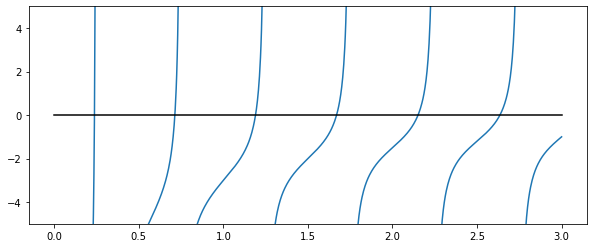

In [11]:
fig, ax  = plt.subplots(figsize=(10,4))
x = np.linspace(1.e-100, 3, 1000)
y = f(x)
mask = np.where(abs(y) > 50)
x[mask] = y[mask] = np.NaN # get rid of vertical line when the function flip sign
ax.plot(x, y)
ax.plot([0, 3], [0, 0], 'k')
ax.set_ylim(-5,5);

We may get different solutions from different starting values.

In [ ]:
opt.fsolve(f, 0.1)

In [ ]:
opt.fsolve(f, 0.6)

In [ ]:
opt.fsolve(f, 1.1)

The function `fsolve` also works for multivariate functions. 

In [12]:
def f(x):
    return [x[1] - x[0]**3 - 2 * x[0]**2 + 1, x[1] + x[0]**2 - 1]

In [13]:
opt.fsolve(f, np.array([1, 1]))

array([0.73205081, 0.46410162])

### Bisection method for univariate functions

For univariate functions, a simple (but inefficient and  method for solving nonlinear equations is the bisection method, as illustrated below.

We are seeking a solution to $f(x)=0$ and are told that the solution lies in the interval $[a,b]$. 
1. Evaluate the function at the end points ($a$ and $b$)
2. Evaluate the function at the mid-point ($m=(a+b)/2$).  
3. If the sign of $f(a)$ is the same as that of $f(m)$ it means the root is in the right half of the interval, so set $a=m$. Otherwise, the root must be in the left half, so set $b=m$.
4. Repeat steps 2 and 3 until $b-a$ is sufficiently small.

Text(0.5, 1.0, 'Bisection method in action')

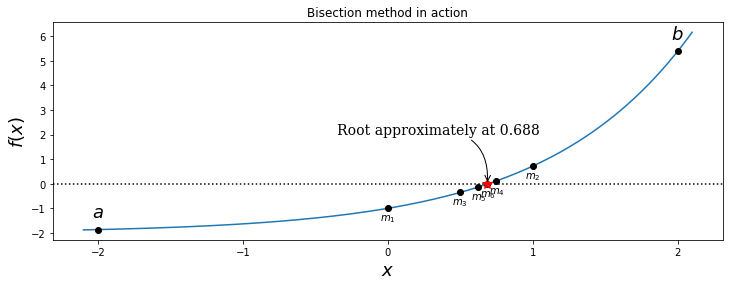

In [14]:
# define a function, desired tolerance and starting interval [a, b]
f = lambda x: np.exp(x) - 2
tol = 0.1
a, b = -2, 2
x = np.linspace(-2.1, 2.1, 1000)

# graph the function f
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(x, f(x), lw=1.5)
ax.axhline(0, ls=':', color='k')
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$f(x)$', fontsize=18)

# find the root using the bisection method and visualize
# the steps in the method in the graph
fa, fb = f(a), f(b)

ax.plot(a, fa, 'ko')
ax.plot(b, fb, 'ko')
ax.text(a, fa + 0.5, r"$a$", ha='center', fontsize=18)
ax.text(b, fb + 0.5, r"$b$", ha='center', fontsize=18)

n = 1
while b - a > tol:
    m = a + (b - a)/2
    fm = f(m)

    ax.plot(m, fm, 'ko')
    ax.text(m, fm - 0.5, r"$m_%d$" % n, ha='center')
    n += 1
    
    if np.sign(fa) == np.sign(fm): # -1, 0, or 1 when <, =, or > 0
        a, fa = m, fm
    else:
        b, fb = m, fm

ax.plot(m, fm, 'r*', markersize=10)
ax.annotate("Root approximately at %.3f" % m,
            fontsize=14, family="serif",
            xy=(a, fm), xycoords='data',
            xytext=(-150, +50), textcoords='offset points', 
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=-.5"))

ax.set_title("Bisection method in action")

# Newton's Method

A more sophisticated method is Newton's method, in which
$$x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}.$$
<img src="https://www.ams.sunysb.edu/~jiao/teaching/ams561/images/newtons.png" width="300">

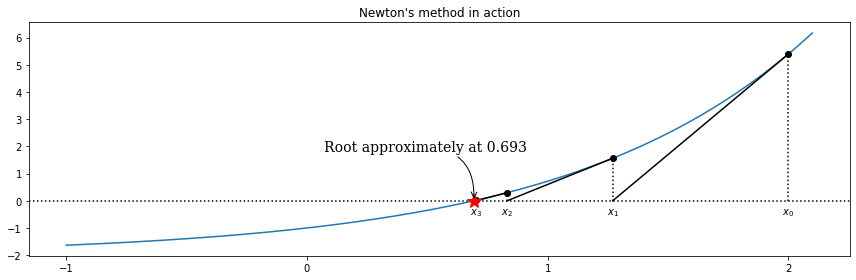

In [17]:
# define a function, desired tolerance and starting point xk
tol = 0.01
xk = 2

s_x = sympy.symbols("x")
s_f = sympy.exp(s_x) - 2

# f = lambda x: sympy.lambdify(s_x, s_f, 'numpy')(x) # using lambdify convert sympy into numpy
# fp = lambda x: sympy.lambdify(s_x, sympy.diff(s_f, s_x), 'numpy')(x) # input of s_x, and function, into numpy

f = sympy.lambdify(s_x, s_f, 'numpy')
fp = sympy.lambdify(s_x, sympy.diff(s_f, s_x), 'numpy')

x = np.linspace(-1, 2.1, 1000)

# setup a graph for visualizing the root finding steps
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(x, f(x))
ax.axhline(0, ls=':', color='k')

# repeat Newton's method until convergence to the desired tolerance has been reached
n = 0
while abs(f(xk)) > tol: # it should have a positive value so using abs
    xk_new = xk - f(xk) / fp(xk)

    ax.plot([xk, xk], [0, f(xk)], color='k', ls=':')
    ax.plot(xk, f(xk), 'ko')
    ax.text(xk, -.5, r'$x_%d$' % n, ha='center')
    ax.plot([xk, xk_new], [f(xk), 0], 'k-')

    xk = xk_new
    n += 1

ax.plot(xk, f(xk), 'r*', markersize=15)
ax.annotate("Root approximately at %.3f" % xk,
            fontsize=14, family="serif",
            xy=(xk, f(xk)), xycoords='data',
            xytext=(-150, +50), textcoords='offset points', 
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=-.5"))

ax.set_title("Newton's method in action")
ax.set_xticks([-1, 0, 1, 2])
fig.tight_layout()


Most practical methods are some variate of Newton's method or quasi-Newton methods, such as the secant method.

The secant method can be interpreted as using a finite difference approximation to estimate the derivative in Newton's method. Similar to the bisection method, the secant method uses two data points to determine a third one at each step. However, it uses not only the signs but also the values to draw a secant line through two points.
<img src="https://www.ams.sunysb.edu/~jiao/teaching/ams561/images/secant.png" width="400">

The slope of the scant is given by
$$s_k = \frac{f(x_k)-f(x_{k-1})}{x_k-x_{k-1}}.$$
The intersection of the secant with the $x$ axis is then
$$x_{k+1} = x_k - \frac{f(x_k)}{s_k} = x_k + \frac{x_k-x_{k-1}}{f(x_{k-1}) / f(x_k) - 1}.$$

We will leave this as an exercise in the homework.

In [ ]:
import math
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

## Univariate Optimization

The *optimization* problem is to find maxima and minima of an *objective function*. Optimization is often referred to as *minimization*, because maximization can be formulated as minimizing its negative value. 

Optimization is closely related to root finding: because at the minima the slope (or first derivative) of the curve is zero for smooth functions. In general, optimization algorithms only finds local extrema.

Let's first look at how to find the minima of a simple function of a single variable:

In [18]:
def f(x):
    ''' The target function '''
    return x**4 + 4*x**3 + (x-2)**2

def dfdx(x):
    ''' The slope or first derivative of f'''
    return 4*x**3 + 12*x**2 + 2*(x-2)

def d2fdx2(x):
    ''' The curvature or second derivative of f'''
    return 12*x**2 + 24*x + 2

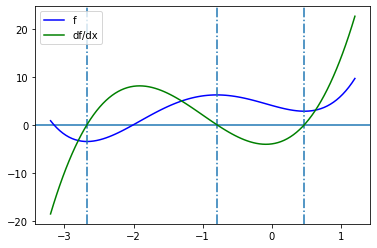

In [19]:
fig, ax  = plt.subplots()
x = np.linspace(-3.2, 1.2, 100)
ax.axhline(0)
ax.plot(x, f(x), "-b", label="f")
ax.axvline(-0.796635786203095, linestyle="-.")
ax.axvline( 0.469617434058037, linestyle="-.")
ax.axvline(-2.67298164785494, linestyle="-.")
ax.plot(x, dfdx(x), "-g", label="df/dx")
#ax.plot(x, d2fdx2(x), "-r", label="d2f/dx2")
ax.legend(loc="upper left");

At a minimum the value of the function must increase if we move left or right --- i.e., 

* The minima are at *critical points* where the slope of the curve, or its first derivative, is zero.
* There must be positive curvature (or the second derivative $\frac{d^2f}{dx^2} > 0$).

At a maximimum, the slope again must be zero, but there must be negative curvature (since the function must decrease if we move left or right)

For simple problems, like the above, this can be solved analytically.

If we are solving for an extremum or critical point by solving $\frac{df}{dx}=0$ we can look at the second derivative to see what sort of critical point we have found.
* $\frac{d^2f}{dx^2}<0 \ \ \implies \ \ $ maximum
* $\frac{d^2f}{dx^2}=0 \ \ \implies \ \ $ inflection
* $\frac{d^2f}{dx^2}>0 \ \ \implies \ \ $ minimum

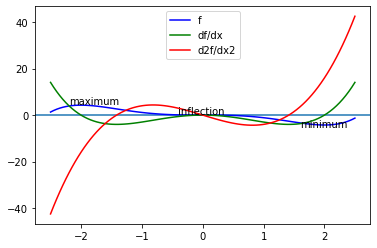

In [21]:
def ff(x):
    return x**5/5 - 4*x**3/3

def dff(x):
    return x**2*(x-2)*(x+2)

def d2ff(x):
    return 4*x**3 - 8*x

fig, ax  = plt.subplots()
ax.axhline(0)
x = np.linspace(-2.5, 2.5, 100)
ax.plot(x, ff(x), "-b", label="f")
ax.plot(x, dff(x), "-g", label="df/dx")
ax.plot(x, d2ff(x), "-r", label="d2f/dx2")
ax.annotate('maximum',xy=(-2.2, 4.8))
ax.annotate('inflection',xy=(-0.4, 0.5))
ax.annotate('minimum',xy=(1.6, -5.0))

ax.legend(loc="upper center");

In [ ]:
import sympy

In [22]:
x = sympy.Symbol("x")
objfunc = x**4 + 4*x**3 + (x-2)**2; objfunc

x**4 + 4*x**3 + (x - 2)**2

In [23]:
objfunc.diff(x)

4*x**3 + 12*x**2 + 2*x - 4

In [24]:
sols = sympy.solve(objfunc.diff(x), x); sols

[-1 - 5/(2*(-1/2 - sqrt(3)*I/2)*(27/4 + 3*sqrt(669)*I/4)**(1/3)) - (-1/2 - sqrt(3)*I/2)*(27/4 + 3*sqrt(669)*I/4)**(1/3)/3,
 -1 - (-1/2 + sqrt(3)*I/2)*(27/4 + 3*sqrt(669)*I/4)**(1/3)/3 - 5/(2*(-1/2 + sqrt(3)*I/2)*(27/4 + 3*sqrt(669)*I/4)**(1/3)),
 -1 - (27/4 + 3*sqrt(669)*I/4)**(1/3)/3 - 5/(2*(27/4 + 3*sqrt(669)*I/4)**(1/3))]

In [27]:
sols[0].evalf(chop=True)

-0.796635786203095

In [ ]:
sols[1].evalf(chop=True)

In [ ]:
sols[2].evalf(chop=True)

In [ ]:
objfunc.diff(x, 2).evalf(subs={x:sols[0]}, chop=True) # 2 means second derivative

In [ ]:
objfunc.diff(x, 2).evalf(subs={x:sols[1]}, chop=True)

In [ ]:
objfunc.diff(x, 2).evalf(subs={x:sols[2]}, chop=True)


### Numerical solution

Since most problems cannot be solved symbolically we must usually use numerical computing.

We can use various functions in `scipy.optimize` to find a minimum (or more precisely, to find a critical point).

For univariate problems, the main function is `scipy.optimize.fminbound`, which finds the minimum within an interval.

Limiting the interval searched for a minimum is usually very important
* many functions behave badly outside a certain range
* your problem usually dictates that you want solutions only within a certain physically meaningful range
* especially in many dimensions optimization is hard and the more you tell the optimizer the greater your chance of success

In [28]:
import scipy.optimize as optimize

In [ ]:
optimize.fminbound?

In [ ]:
optimize.fminbound(f, -4, -2)

In [ ]:
optimize.fminbound(f, 0, 2)

In [ ]:
def negf(x):
    return -f(x)
optimize.fminbound(negf, -2, 0)

Alternatively, we could use `scipy.optimize.minimize_scalar` for automatic bracketing.

In [29]:
optimize.minimize_scalar?

In [ ]:
x = optimize.minimize_scalar(f); x

However, automatic bracketing is not fool proof. For example,

In [ ]:
def f(r):
    return 2 * np.pi * r**2 + 2 / r

r = np.linspace(1.e-20, 2, 100)
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(r, f(r), lw=2, color='b')
ax.set_title(r"$f(r) = 2\pi r^2+2/r$", fontsize=18)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_ylim(0, 30)
fig.tight_layout()

In [ ]:
try:
    x = optimize.minimize_scalar(f)
except Exception as e:
    print(e)

In [ ]:
output = optimize.minimize_scalar(f, bracket=(0.1, 4)); output.x

## Optional Material: Methods for Univariate Optimization

### Golden section search

The golden-section search for minimization is analogous to the bisection method for root finding. It starts with an interval with opposite signs of slopes, and repeatedly shrinks the interval until the length of interval is within some tolerance.

<img src="https://www.ams.sunysb.edu/~jiao/teaching/ams561/images/golden_section.png" width="400">
<img src="https://www.ams.sunysb.edu/~jiao/teaching/ams561/images/golden_section_shrink.png" width="280">

The following code implements the method.

In [30]:
def golden_section(f, a, b, tol):
    '''
    finds a minimum of f(x) within the interval [a,b] using the
    golden-section search. It assumes f has negative slope
    at a and positive slope at b.
    '''

    tau = (np.sqrt(5) - 1) / 2 # golden ratio
    x1 = a + (1 - tau) * (b - a)
    x2 = a + tau * (b - a)
    f1, f2 = f(x1), f(x2)

    k = 0
    while b-a > tol:
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + tau * (b-a)
            f2 = f(x2)
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (1 - tau) * (b-a)
            f1 = f(x1)

        k = k + 1

    x = (a + b) / 2;

    return x, k

In [31]:
x, k = golden_section(f, 0.1, 4, 1.e-12); x

0.46961742713880766

### Successive Parabolic Interpolation

Successive parabolic interpolation for minimization is analogous to the secant method to root finding. It uses three points to construct a quadratic interpolation.

<img src="https://www.ams.sunysb.edu/~jiao/teaching/ams561/images/parabolic_interp.png" width="400">

The method converges faster than golden-section search.

The following code illustrates the idea:

In [ ]:
def spi(f, a, b, tol):
    'SPI minimizes f(x) using successive parabolic interpolation.'

    maxiter = 100

    xs = np.array([a, (a+b)/2, b])
    fx = f(xs)

    for k in range(1, maxiter+1):
        # For simplicity, we use numpy.polyfit for constructing quadratic polynomial
        p = np.polyfit(xs, fx, 2)
        x = -0.5*p[1] / p[0]  # minimum of quadratic a*x**2 + b*x + c is at x=-b/2a

        xs = np.array([xs[1], xs[2], x])
        fx = np.array([fx[1], fx[2], f(x)])

        if abs(xs[2]-xs[1]) < tol * abs(xs[1]):
            break

    x = xs[2]
    return x, k

In [ ]:
np.polyfit?

In [ ]:
x, k = spi(f, 0.1, 4, 1.e-6); x

### Hybrid Method for Efficiency and Robustness
 
Most robust 1-D optimization methods combine the golden-section search and successive parabolic interpolation. This method was due to Richard Brent, and hence it is sometimes referred to as Brent's method. In SciPy, it can be accessed through `brent` or `minimize_scalar`.

In [ ]:
optimize.brent(f, brack=(0.1, 4))

In [ ]:
x = optimize.minimize_scalar(f, bracket=(0.1, 4), method='Brent'); x

## Further reading

* Chapter 5 of Numerical Python book for nonlinear equations
* Chapter 6 of Numerical Python book on optimization
* SciPy optimization package: http://scipy-lectures.github.com/advanced/mathematical_optimization/index.html

## Acknowledgements

Adapted from J.R. Johansson's Scientific Python Lectures available at [http://github.com/jrjohansson/scientific-python-lectures](http://github.com/jrjohansson/scientific-python-lectures).